# Translation with a Seq2Seq Network and Attention

이번 실습에는 프랑스어를 영어로 번역하는 모델을 통해 RNN과 attention을 사용해보도록 하겠습니다.

# 0. Requirements

In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/data')

Mounted at /content/gdrive/


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from pdb import set_trace as bp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Loading Data Files

[데이터 다운로드](https://download.pytorch.org/tutorial/data.zip)

본 실습에서 사용되는 데이터는 수천 개의 영어-프랑스어 pair이며 데이터의 경로는 `/gdrive/My Drive/Colab Notebooks/data/eng-fra.txt`입니다.

본 데이터를 관리하기 위해서 `Lang`이라는 클래스를 사용합니다. `Lang`내에서 word들은 index로 관리되며, `word2index`와 `index2word`를 통해 이를 추적할 수 있습니다. 또한 `word2count`를 통해 각 word의 빈도를 저장합니다.

In [3]:
# Start Of Sentence
SOS_token = 0
# End Of Sentence
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

데이터 내의 word들은 유니코드로 되어있는데 단순화를 위해 모든 문자를 ASCII로 변환하고, 모든 대문자를 소문자로 바꾸고, 구두점을 지워줍니다.

In [4]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    # Unicode -> Ascii, 대문자 -> 소문자
    s = unicodeToAscii(s.lower().strip())
    # 구두점 지우기
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

데이터 파일을 읽기 위해 파일을 line으로 나누고 각 line에서 pair를 추출합니다. 데이터 파일은 영어→프랑스어로 되어있으며 프랑스어→영어로 번역하는 경우를 위해 `reverse` flag가 사용됩니다.

In [5]:
def readLangs(lang1, lang2, reverse=False):
    # lang1, lang2: language name
    print("Reading lines...")

    # 파일을 읽고 line으로 분리
    lines = open('./%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 line을 pair로 분리하고 normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # pair을 뒤집고, Lang 인스턴스 생성
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

본 데이터 파일에는 10만개 이상의 pair가 존재하나 실습을 위해 길이가 10단어 이하이며 "I am ...", "He is ..." 등과 같이 단순한 문장 구조를 가지는 문장들만 필터링하여 데이터를 단순화 시킵니다.

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

데이터를 준비하는 과정은 다음과 같이 진행됩니다.
- 텍스트 파일을 읽고 line으로 분리한 뒤, 각 line을 pair로 분리한 뒤 이를 normalize.
- 텍스트를 길이와 문장 구조로 필터링.
- Pair를 이룬 문장들로 word 리스트 생성.

In [7]:
def prepareData(lang1, lang2, reverse=False):
    # lang1 = 'eng', lang2 = 'fra'
    # 텍스트 파일을 읽고 line으로 분리한 뒤, 각 line을 pair로 분리한 뒤 이를 normalize.
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    # 텍스트를 길이와 문장 구조로 필터링.
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    # Pair를 이룬 문장들로 word 리스트 생성.
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

다음은 아래의 데이터 준비 코드를 실행시켰을때의 결과의 예시입니다.

Out:
```
    Reading lines...
    Read 135842 sentence pairs
    Trimmed to 10599 sentence pairs
    Counting words...
    Counted words:
    fra 4345
    eng 2803
    ['je suis toubib .', 'i m a doctor .']
```

In [8]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis trop vieux pour aller en allemagne .', 'i m too old to go to germany .']


# 2. Seq2Seq 모델

Recurrent Neural Network(RNN)는 시퀀스를 다루는 모델로 다음 단계의 input으로 자신의 output을 사용하는 네트워크입니다.

Seq2seq 네트워크는 encoder decoder network라고도 불리며, 두 개의 RNN인 인코더와 디코더로 구성된 모델입니다. 인코더는 input sequence를 읽어 단일 벡터를 출력하고, 디코더는 해당 벡터를 읽어 output sequence를 생성합니다.

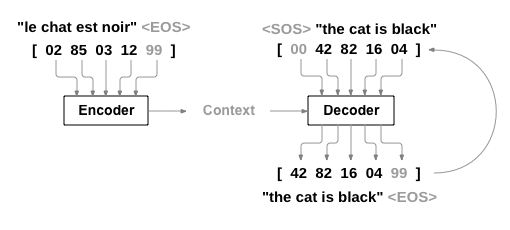

단일 RNN으로 수행하는 sequence prediction의 경우 모든 input에는 그에 상응하는 output이 있으나, seq2seq모델은 sequence의 길이와 순서에 자유롭기 때문에 두 언어를 번역하는데 많이 사용됩니다.

다음 예제 “Je ne suis pas le chat noir” → “I am not the black cat” 를 살펴 봅시다. input 문장의 단어 대부분은 output 문장에서 직역(“chat noir” 와 “black cat”)되지만 단어의 순서가 동일하지 않은 경우도 있습니다. 또한 “ne/pas” 구조로 인해 입력 문장에 단어가 하나 더 있습니다. 이 때문에 input 단어의 시퀀스를 직역해서 정확한 번역을 만드는 것은 어려울 것입니다.

Seq2seq 모델을 사용하면 인코더는 하나의 벡터를 생성합니다. 이상적인 경우에 입력 시퀀스의 “의미”를 문장의 N 차원 공간에 있는 단일 지점인 단일 벡터으로 인코딩합니다.

## 2.1. Encoder
Seq2seq 네트워크의 인코더는 input 문장의 모든 단어에 대해 어떤 값을 출력하는 RNN입니다. 모든 입력 단어에 대해 인코더는 벡터와 hidden state를 출력하고 다음 input 단어를 위해 그 hidden state를 사용합니다.

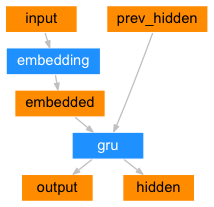

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        # nn.GRU(input_size=hidden_size, hidden_size=hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # input: a word, size: (1)
        # hidden: hidden state
        embedded = self.embedding(input).view(1, 1, -1) # (1, embedding_dim) -> (1, 1, embedding_dim)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 2.2. Decoder

디코더는 인코더의 output 벡터를 받아서 번역된 단어 시퀀스를 출력합니다.

가장 간단한 seq2seq 디코더는 인코더의 마지막 output만을 이용합니다. 이 마지막 output은 전체 sequence에서 문맥을 인코드하기 때문에 문맥 벡터(context vector)로 불립니다. 이 문맥 벡터는 디코더의 초기 hidden state로 사용 됩니다.

디코딩의 매 단계에서 디코더에게 input 토큰과 hidden state가 주어집니다. 초기 input 토큰은 문자열-시작 (start-of-string) `<SOS>` 토큰이고, 첫 hidden state는 문맥 벡터(인코더의 마지막 hidden state) 입니다.

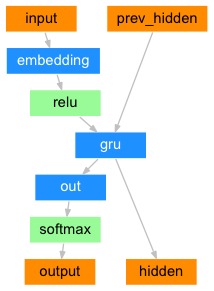

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        # input: a word
        # hidden: hidden state
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

# 3. Training
## 3.1. Preparing Training Data

학습을 위해서, 각 pair마다 입력 tensor(input 문장 내의 단어들의 index)와 목표 tensor(target 문장 내의 단어들의 index)가 필요합니다. 이 벡터들을 생성하는 동안 두 시퀀스에 EOS 토큰을 추가 합니다.

In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## 3.2. Training the Model

학습을 위해서 인코더에 input 문장을 넣고 모든 output과 최신 hidden state를 추적합니다. 그런 다음 디코더에 첫 번째 input으로 `<SOS>` 토큰과 인코더의 마지막 hidden state가 첫번째 hidden state로 제공됩니다.

“Teacher forcing”은 다음 input으로 디코더의 예측을 사용하는 대신 실제 target output을 다음 입력으로 사용하는 컨셉입니다. “Teacher forcing”을 사용하면 수렴이 빨리되지만 학습된 네트워크가 사용될 때 불안정성을 보일 수도 있습니다.

Teacher-forced 네트워크의 output이 일관된 문법으로 읽지만 정확한 번역과는 거리가 멀다는 것을 볼 수 있습니다. 직관적으로 output 문법을 표현하는 법을 배우고 교사가 처음 몇 단어를 말하면 의미를 “선택” 할 수 있지만, 번역에서 처음으로 문장을 만드는 법은 잘 배우지 못합니다.

PyTorch의 autograd가 제공하는 자유 덕분에 간단한 if 문으로 teacher forcing을 사용할지 아니면 사용하지 않을지를 선택할 수 있습니다. Teacher forcing을 더 많이 사용하려면 `teacher_forcing_ratio`를 확인하십시오.

In [12]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    """
    Args:
      input_tensor:
      target_tensor: 
      encoder: 
      decoder:
      encoder_optimizer:
      decoder_optimizer:
      criterion:
      max_length: 
    """
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # pytorch sequence input size: [seq_len, batch_size, input_size]
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    
    # [?, 1, input_size]
    
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

다음은 현재 시간과 진행률을 고려해 경과된 시간과 남은 예상 시간을 출력하는 헬퍼 함수입니다.

In [13]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

전체 학습은 다음과 같이 진행됩니다.

- 타이머 시작

- Optimizers와 criterion 초기화

- 학습 pair의 세트 생성

- 도식화를 위한 빈 loss 배열 시작

그런 다음 우리는 여러 번 train 을 호출하며 때로는 진행률 (예제의 %, 현재까지의 예상 시간)과 평균 손실을 출력합니다.

In [14]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    # Training data
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    # Criterion (== Cross Entropy)
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## 3.3. Plotting Results

`matplotlib`으로 학습 중에 저장된 손실 값 `plot_losses`의 배열을 사용하여 도식화합니다.

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## 3.4. Evaluation

평가는 대부분 학습과 동일하지만 목표가 없으므로 각 단계마다 디코더의 예측을 되돌려 전달합니다. 단어를 예측할 때마다 그 단어를 출력 문자열에 추가합니다. 만약 EOS 토큰을 예측하면 거기에서 멈춥니다.

In [16]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

Training 세트에 있는 임의의 문장을 평가하고 input, target 및 output을 출력하여 주관적인 품질 판단을 내릴 수 있습니다.

In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 3.5. Training and Evaluating

이러한 모든 헬퍼 함수를 이용해서 (추가 작업처럼 보이지만 여러 실험을 더 쉽게 수행 할 수 있습니다.) 실제로 네트워크를 초기화하고 학습을 시작할 수 있습니다.

입력 문장이 많이 필터링되었음을 기억하십시오. 이 작은 데이터 세트의 경우 256 크기의 hidden node와 단일 GRU layer 같은 상대적으로 작은 네트워크를 사용할 수 있습니다. 시간 관계 상 필터링된 문장 중 4만개를 학습에 사용하며 학습에는 약 10분 정도의 시간이 소요됩니다.

0m 21s (- 6m 39s) (2000 5%) 3.2707
0m 40s (- 6m 5s) (4000 10%) 2.7734
0m 59s (- 5m 38s) (6000 15%) 2.6032
1m 18s (- 5m 14s) (8000 20%) 2.4024
1m 37s (- 4m 53s) (10000 25%) 2.2577
1m 56s (- 4m 32s) (12000 30%) 2.1250
2m 17s (- 4m 14s) (14000 35%) 2.0122
2m 36s (- 3m 54s) (16000 40%) 1.9215
2m 57s (- 3m 36s) (18000 45%) 1.8013
3m 16s (- 3m 16s) (20000 50%) 1.7329
3m 35s (- 2m 56s) (22000 55%) 1.6103
3m 55s (- 2m 36s) (24000 60%) 1.5696
4m 14s (- 2m 16s) (26000 65%) 1.5116
4m 33s (- 1m 57s) (28000 70%) 1.4782
4m 52s (- 1m 37s) (30000 75%) 1.3664
5m 11s (- 1m 17s) (32000 80%) 1.3555
5m 31s (- 0m 58s) (34000 85%) 1.2384
5m 50s (- 0m 38s) (36000 90%) 1.2014
6m 9s (- 0m 19s) (38000 95%) 1.1141
6m 28s (- 0m 0s) (40000 100%) 1.0751


<Figure size 432x288 with 0 Axes>

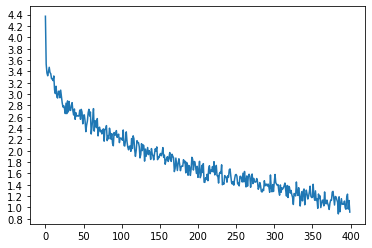

In [18]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder1 = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder1, decoder1, 40000, print_every=2000)

In [19]:
evaluateRandomly(encoder1, decoder1)

> tu es fort sceptique .
= you re very skeptical .
< you re very wise . <EOS>

> je ne fais que mon travail .
= i m just doing my job .
< i m doing my my . <EOS>

> j en crois pas mes yeux .
= i m in way over my head .
< i m not my of my . <EOS>

> je pense que tu as raison .
= you re right i think .
< you re right i think . <EOS>

> il sait jouer de la guitare .
= he is able to play the guitar .
< he is able to his his . <EOS>

> nous ne sommes pas les bienvenus .
= we re not welcome .
< we re not welcome . <EOS>

> vous etes fort attirants .
= you re very attractive .
< you re very sophisticated . <EOS>

> il n est pas au bureau .
= he is out of the office .
< he is not at the . . <EOS>

> il n est bon a rien .
= he is good for nothing .
< he is good at good . <EOS>

> c est une enfoiree .
= she s a dog .
< she s a real . <EOS>



# 4. Attention

## 4.1. Attention Decoder

문맥 벡터만 인코더와 디코더 사이로 전달 된다면, 단일 벡터가 전체 문장을 인코딩 해야하는 부담을 가지게 됩니다.

Attention은 디코더 네트워크가 자기 output의 모든 단계에서 인코더 output의 다른 부분에 “집중” 할 수 있게 합니다. 먼저, attention 가중치의 세트를 계산합니다. 이것은 가중치 조합을 만들기 위해서 인코더 output 벡터와 곱해집니다. 그 결과(코드에서 `attn_applied`)는 입력 시퀀스의 특정 부분에 관한 정보를 포함해야하고 따라서 디코더가 알맞은 output 단어를 선택하는 것을 도와줍니다.

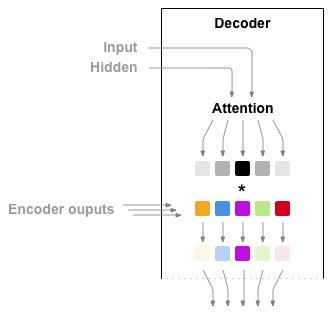

Attention 가중치 계산은 디코더의 input 및 hidden state를 input으로 사용하는 다른 feed-forwad layer인 `attn`으로 수행됩니다. 학습 데이터에는 모든 크기의 문장이 있기 때문에 이 layer를 실제로 만들고 학습시키려면 적용 할 수 있는 최대 문장 길이 (인코더 output을 위한 입력 길이)를 선택해야 합니다. 최대 길이의 문장은 모든 attention 가중치를 사용하지만 더 짧은 문장은 처음 몇 개만 사용합니다.

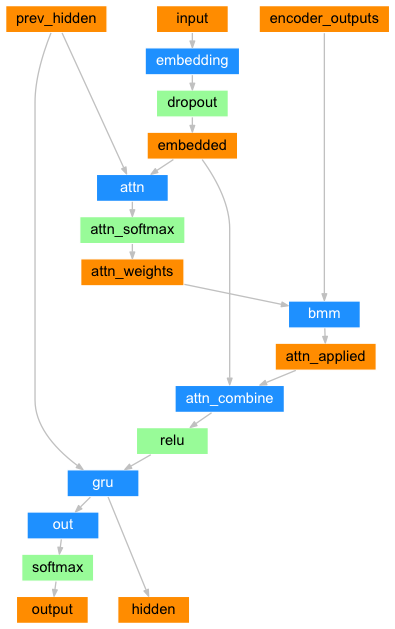

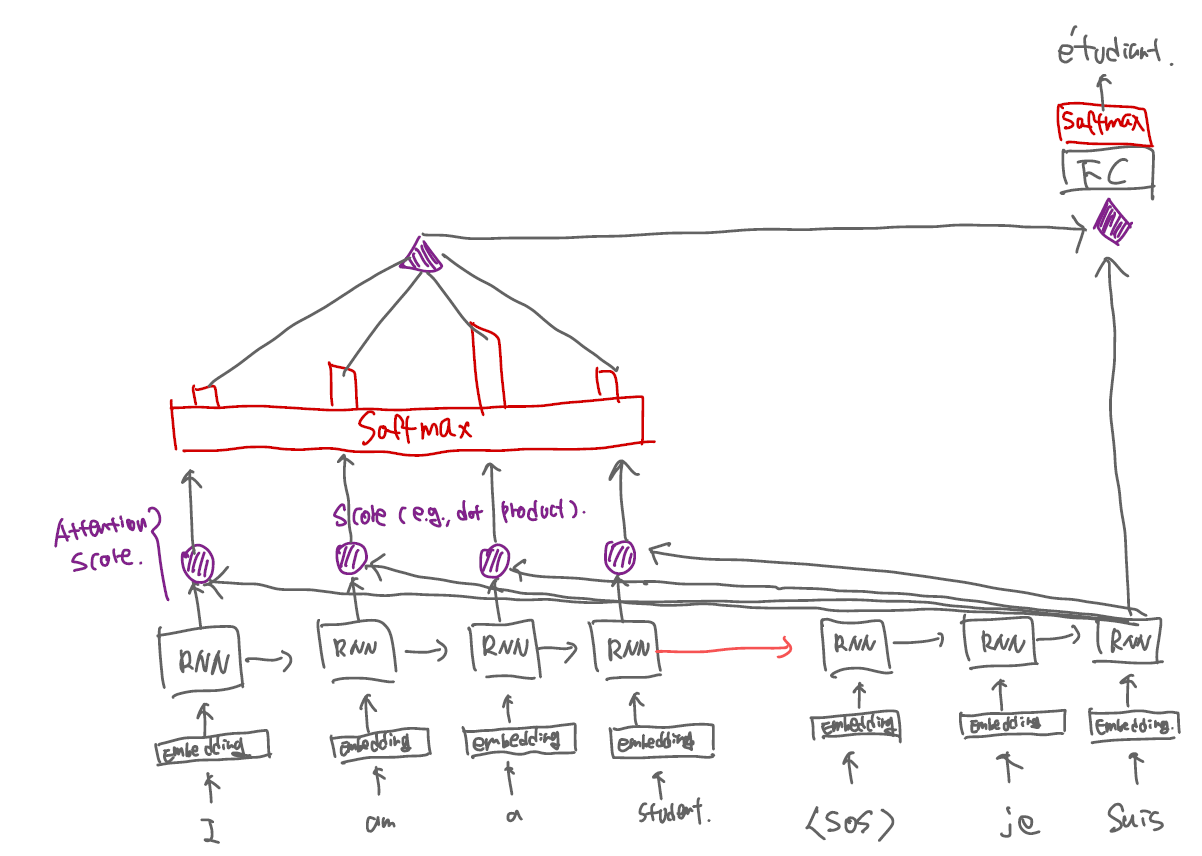

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        
        # Query: cat(decoder_input, pre_hidden)
        # Key: self.attn의 column
        # Value: encoder_outputs 

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

## 4.2. Training

Attention 디코더의 input이 바뀌었기 때문에 이를 반영한 `trainAttn`함수를 만들어줍니다.

In [21]:
teacher_forcing_ratio = 0.5

def trainAttn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)
    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

마찬가지로 `train`대신 `trainAttn`을 호출하는 `trainItersAttn`함수를 만들어줍니다.

In [22]:
def trainItersAttn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = trainAttn(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

## 4.3. Evaluation

`evaluateAttn`은 `evaluate`와 동일한 기능을 하며 추가적으로 나중에 도식화를 위해 디코더의 attention 출력을 저장합니다.

In [23]:
def evaluateAttn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

## 4.4. Training and Evaluating

### 연습

Encoder는 `EncoderRNN`를 사용하고 decoder는 `AttnDecoderRNN`를 사용하여 `trainItersAttn`를 이용해 attention seq2seq 모델을 학습시켜 봅시다. Hidden node의 크기는 256으로 지정해주시기 바랍니다.

다음은 완성된 training 코드를 실행시켰을때 출력의 예시입니다.

Out:
```
2m 15s (- 43m 1s) (2000 5%) 3.1905
4m 38s (- 41m 50s) (4000 10%) 2.6736
6m 57s (- 39m 26s) (6000 15%) 2.5005
9m 19s (- 37m 18s) (8000 20%) 2.3355
11m 41s (- 35m 4s) (10000 25%) 2.2117
14m 2s (- 32m 46s) (12000 30%) 2.0521
16m 27s (- 30m 33s) (14000 35%) 1.9922
18m 53s (- 28m 19s) (16000 40%) 1.8422
21m 15s (- 25m 59s) (18000 45%) 1.7490
23m 36s (- 23m 36s) (20000 50%) 1.6682
26m 0s (- 21m 16s) (22000 55%) 1.5688
28m 20s (- 18m 53s) (24000 60%) 1.4931
30m 46s (- 16m 34s) (26000 65%) 1.4187
33m 9s (- 14m 12s) (28000 70%) 1.4004
35m 34s (- 11m 51s) (30000 75%) 1.3563
37m 54s (- 9m 28s) (32000 80%) 1.3237
40m 18s (- 7m 6s) (34000 85%) 1.2123
42m 37s (- 4m 44s) (36000 90%) 1.1757
45m 2s (- 2m 22s) (38000 95%) 1.1303
47m 19s (- 0m 0s) (40000 100%) 1.1067
```

0m 30s (- 9m 35s) (2000 5%) 3.1850
0m 59s (- 8m 52s) (4000 10%) 2.6661
1m 28s (- 8m 19s) (6000 15%) 2.4972
1m 56s (- 7m 47s) (8000 20%) 2.2691
2m 25s (- 7m 17s) (10000 25%) 2.1446
2m 54s (- 6m 48s) (12000 30%) 2.0768
3m 25s (- 6m 22s) (14000 35%) 1.9052
3m 55s (- 5m 52s) (16000 40%) 1.8451
4m 24s (- 5m 23s) (18000 45%) 1.7433
4m 53s (- 4m 53s) (20000 50%) 1.6828
5m 22s (- 4m 23s) (22000 55%) 1.6092
5m 51s (- 3m 54s) (24000 60%) 1.5345
6m 21s (- 3m 25s) (26000 65%) 1.4332
6m 50s (- 2m 55s) (28000 70%) 1.3277
7m 19s (- 2m 26s) (30000 75%) 1.3027
7m 49s (- 1m 57s) (32000 80%) 1.2537
8m 18s (- 1m 27s) (34000 85%) 1.2070
8m 47s (- 0m 58s) (36000 90%) 1.1938
9m 17s (- 0m 29s) (38000 95%) 1.1015
9m 46s (- 0m 0s) (40000 100%) 1.0391


<Figure size 432x288 with 0 Axes>

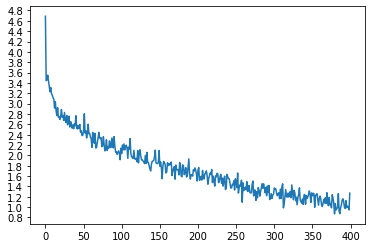

In [25]:
## Start your code
encoder2 = None
decoder2 = None
##End your code
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainItersAttn(encoder2, decoder2, 40000, print_every=2000)

`evaluateRandomlyCompare`는 simple decoder를 사용한 모델과 attention decoder를 사용한 모델의 결과를 비교합니다.

In [26]:
def evaluateRandomlyCompare(encoder1, decoder1, encoder2, decoder2, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Input\t\t>', pair[0])
        print('Target\t\t=', pair[1])
        output_words = evaluate(encoder1, decoder1, pair[0])
        output_sentence = ' '.join(output_words)
        print('Simple\t\t<', output_sentence)
        output_words, attentions = evaluateAttn(encoder2, decoder2, pair[0])
        output_sentence = ' '.join(output_words)
        print('Attention\t<', output_sentence)
        print('')

Simple decoder와 attention decoder의 성능을 비교해봅시다.

In [27]:
evaluateRandomlyCompare(encoder1, decoder1, encoder2, decoder2)

Input		> il observe mon moindre mouvement .
Target		= he is watching my every move .
Simple		< he s raking my my . <EOS>
Attention	< he s my my my . . <EOS>

Input		> tout va bien .
Target		= i m fine .
Simple		< i m all right . <EOS>
Attention	< i m fine . <EOS>

Input		> tu es naive .
Target		= you re naive .
Simple		< you re naive . <EOS>
Attention	< you re naive . <EOS>

Input		> tu fais un boulot excellent .
Target		= you re doing an excellent job .
Simple		< you re doing the right . <EOS>
Attention	< he s a a liar . <EOS>

Input		> tu es tres effrontee .
Target		= you re very forward .
Simple		< you re very forward . <EOS>
Attention	< you re very forward . <EOS>

Input		> je suis celibataire .
Target		= i m single .
Simple		< i am a . . <EOS>
Attention	< i m single . <EOS>

Input		> nous apprenons le chinois .
Target		= we re learning chinese .
Simple		< we re doing it . <EOS>
Attention	< we re learning chinese . <EOS>

Input		> j en suis contente .
Target		= i m happy with that 

## 4.5. Visualizing Attention

Attention 메커니즘의 유용한 속성 중 하나는 해석 가능성이 높은 output입니다. Input 시퀀스의 특정 인코더 output에 가중치를 부여하는 데 사용되므로 각 시간 단계에서 네트워크가 가장 집중되는 위치를 파악할 수 있습니다.

Attention 출력을 행렬로 표시하기 위해 `plt.matshow(attentions)`를 사용할 수 있습니다.

input = elle a cinq ans de moins que moi .
output = she s two years younger than than . <EOS>
['', 'elle', 'a', 'cinq', 'ans', 'de', 'moins', 'que', 'moi', '.', '<EOS>']
test


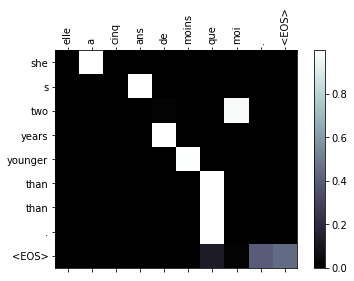

torch.Size([9, 10])
input = elle est trop petit .
output = she is too tall . <EOS>
['', 'elle', 'est', 'trop', 'petit', '.', '<EOS>']
test


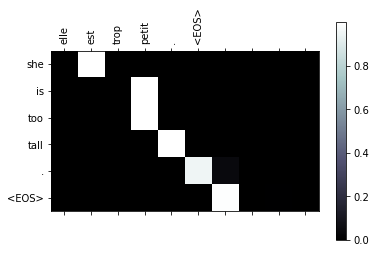

torch.Size([6, 10])
input = je ne crains pas de mourir .
output = i m not afraid to die . <EOS>
['', 'je', 'ne', 'crains', 'pas', 'de', 'mourir', '.', '<EOS>']
test


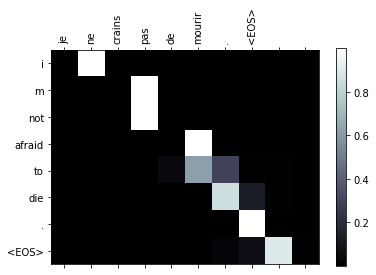

torch.Size([8, 10])
input = c est un jeune directeur plein de talent .
output = he s a talented talented . <EOS>
['', 'c', 'est', 'un', 'jeune', 'directeur', 'plein', 'de', 'talent', '.', '<EOS>']
test


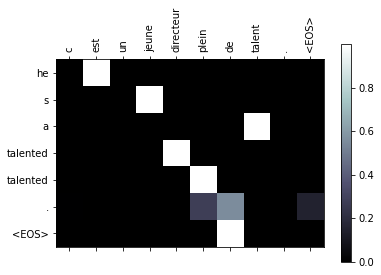

torch.Size([7, 10])


In [32]:
def showAttention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluateAttn(
        encoder2, decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

본 실습에서는 시간 문제상 학습 데이터를 필터링하여 그 수를 대폭 줄이고 train하는 문장수도 4만개에 그쳐서 모델이 완벽한 성능을 내지 못했으나 training sentence 수를 늘리는 것만으로도 좀 더 성능이 올라감을 확인해 보실 수 있을 것입니다.